In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

# Load data
df = pd.read_csv("Data/borg_traces_data.csv")
print(f"✅ Data loaded: {df.shape}")

# Parse CPU histograms into average + std + max
def safe_parse_hist(x):
    try:
        arr = np.array(literal_eval(x), dtype=np.float32)
        return np.mean(arr), np.std(arr), np.max(arr)
    except:
        return np.nan, np.nan, np.nan

cpu_stats = df['cpu_usage_distribution'].apply(safe_parse_hist)
df['cpu_mean'] = cpu_stats.apply(lambda x: x[0])
df['cpu_std']  = cpu_stats.apply(lambda x: x[1])
df['cpu_max']  = cpu_stats.apply(lambda x: x[2])

# Columns to use
features = [
    'cpu_mean', 'cpu_std', 'cpu_max', 'assigned_memory', 'page_cache_memory',
    'priority', 'scheduling_class', 'alloc_collection_id'
]

# Drop rows with missing feature or label
df_clean = df.dropna(subset=features + ['failed']).copy()

# Final feature matrix
X = df_clean[features]
y = df_clean['failed'].astype(int)

print(f"✅ Cleaned data: X={X.shape}, y={y.shape}")


✅ Data loaded: (405894, 34)


c:\Users\binwa\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\binwa\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\binwa\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\binwa\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\binwa\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


✅ Cleaned data: X=(0, 8), y=(0,)


In [3]:
# Show how many rows are lost due to NaNs
print("Missing value count per feature:")
print(df[features + ['failed']].isna().sum())

# How many rows are completely valid?
valid_mask = df[features + ['failed']].notna().all(axis=1)
print(f"\n✅ Rows with all required features and label: {valid_mask.sum()} / {len(df)}")

# Print a few rows if available
if valid_mask.sum() > 0:
    display(df[features + ['failed']][valid_mask].head())
else:
    print("❌ No valid rows found. Check histogram parsing step.")


Missing value count per feature:
cpu_mean               405894
cpu_std                405894
cpu_max                405894
assigned_memory             0
page_cache_memory           0
priority                    0
scheduling_class            0
alloc_collection_id         0
failed                      0
dtype: int64

✅ Rows with all required features and label: 0 / 405894
❌ No valid rows found. Check histogram parsing step.


In [4]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval

# Load data
df = pd.read_csv("Data/borg_traces_data.csv")
print(f"✅ Data loaded: {df.shape}")

# Robust parser for cpu_usage_distribution
def robust_hist_stats(x):
    try:
        if not isinstance(x, str): return (np.nan, np.nan, np.nan)
        # Replace multiple spaces with commas if needed
        cleaned = re.sub(r"\s+", ",", x.strip())
        arr = np.array(literal_eval(cleaned), dtype=np.float32)
        if arr.size < 10: return (np.nan, np.nan, np.nan)
        return np.mean(arr), np.std(arr), np.max(arr)
    except:
        return (np.nan, np.nan, np.nan)

# Apply parsing
hist_stats = df['cpu_usage_distribution'].apply(robust_hist_stats)
df['cpu_mean'] = hist_stats.apply(lambda x: x[0])
df['cpu_std']  = hist_stats.apply(lambda x: x[1])
df['cpu_max']  = hist_stats.apply(lambda x: x[2])

# Final feature list
features = [
    'cpu_mean', 'cpu_std', 'cpu_max', 'assigned_memory', 'page_cache_memory',
    'priority', 'scheduling_class', 'alloc_collection_id'
]

# Clean dataset
df_clean = df.dropna(subset=features + ['failed']).copy()
X = df_clean[features]
y = df_clean['failed'].astype(int)

print(f"✅ Cleaned dataset: X={X.shape}, y={y.shape}")


✅ Data loaded: (405894, 34)
✅ Cleaned dataset: X=(390219, 8), y=(390219,)


In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

# 📊 Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ⚖️ Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 🧬 Apply SMOTE to oversample minority class in training
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Report class balance
print("🧾 Class balance after SMOTE:")
print(Counter(y_train_balanced))


🧾 Class balance after SMOTE:
Counter({0: 239429, 1: 239429})


c:\Users\binwa\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     59858
           1       0.85      0.97      0.91     18186

    accuracy                           0.95     78044
   macro avg       0.92      0.96      0.94     78044
weighted avg       0.96      0.95      0.96     78044

🔥 ROC AUC Score: 0.993
⚡ Avg Inference Time per Sample: 0.000001 sec


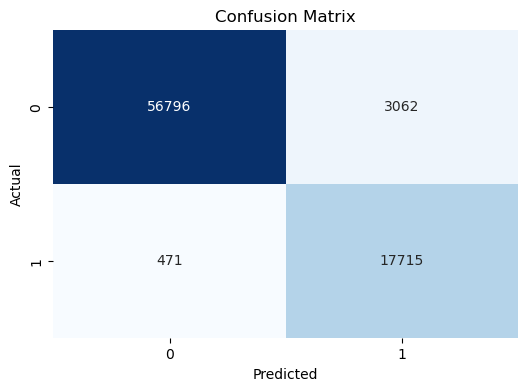

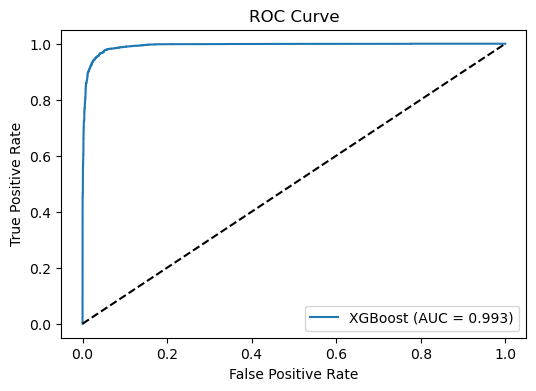

In [6]:
import xgboost as xgb
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# 🧠 Train XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train_balanced, y_train_balanced)

# 🕒 Inference time tracking
start = time.time()
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]
inference_time = (time.time() - start) / len(y_test)

# 📈 Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print(f"🔥 ROC AUC Score: {roc_auc_score(y_test, y_prob):.3f}")
print(f"⚡ Avg Inference Time per Sample: {inference_time:.6f} sec")

# 📊 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
os.makedirs("visualization", exist_ok=True)
plt.savefig("visualization/confusion_matrix_xgb.png")
plt.show()

# 📈 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.3f})'.format(roc_auc_score(y_test, y_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("visualization/roc_curve_xgb.png")
plt.show()


In [12]:
import os
import numpy as np
import pandas as pd

# Ensure predictions folder exists
os.makedirs("predictions", exist_ok=True)

# 👇 Replace these with actual variables used in each pipeline
model_name = "XGB_Smote"  # e.g., xgb, lstm, gnn, svm
predicted_labels = y_pred      # array of predicted labels (binary)
true_labels_array = y_test     # corresponding true labels (binary)

# Save as .npy for fast loading
np.save(f"predictions/{model_name}_preds.npy", predicted_labels)
np.save(f"predictions/{model_name}_labels.npy", true_labels_array)

# Save as .csv for inspection
pd.DataFrame({
    "true": true_labels_array,
    "pred": predicted_labels
}).to_csv(f"predictions/{model_name}_results.csv", index=False)

print(f"✅ Saved predictions and labels for: {model_name}")


✅ Saved predictions and labels for: XGB_Smote


100%|===================| 78020/78044 [04:25<00:00]        

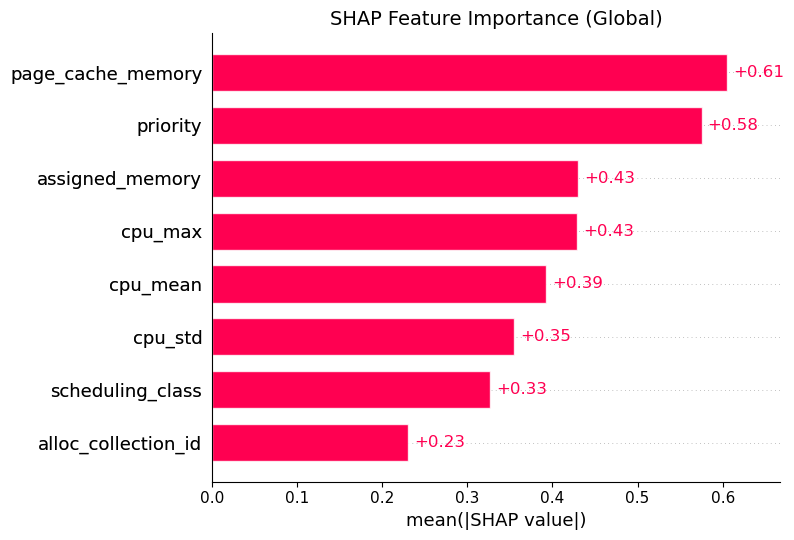

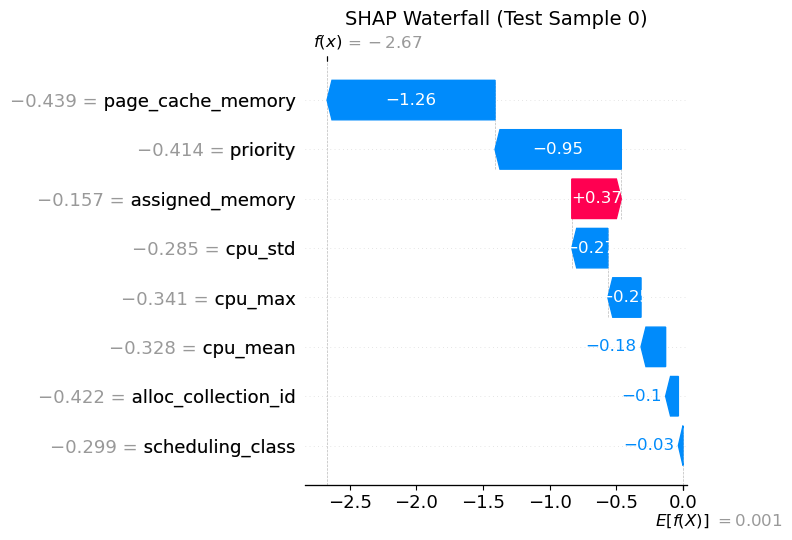

In [10]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Re-wrap test data
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# SHAP Explainer
explainer = shap.Explainer(model, X_train_balanced)
shap_values = explainer(X_test_df, check_additivity=False)

# ✅ Global Feature Importance
plt.figure()
shap.plots.bar(shap_values, max_display=10, show=False)
plt.title("SHAP Feature Importance (Global)", fontsize=14)
plt.tight_layout()
plt.savefig("visualization/shap_importance_named_xgb.png")
plt.show()

# ✅ Local Waterfall Explanation
plt.figure()
shap.plots.waterfall(shap_values[0], max_display=10, show=False)
plt.title("SHAP Waterfall (Test Sample 0)", fontsize=14)
plt.tight_layout()
plt.savefig("visualization/shap_waterfall_named_sample.png")
plt.show()
